## Import Packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords   
import string
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Install Tensorflow with GPU support (Make sure your system support GPU-cuda) : python3 -m pip install 'tensorflow[and-cuda]'
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM, Dropout, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
import numpy as np

[nltk_data] Downloading package punkt_tab to /home/varun/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/varun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-12-20 16:48:14.639341: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 16:48:14.648887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734693494.660071  366286 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734693494.663457  366286 cuda_blas.cc:1418] Unable to register

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Enable CUDA for TensorFlow
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("CUDA is enabled. GPU is available and will be used for computations.")
    except RuntimeError as e:
        print(f"Failed to set memory growth: {e}")
else:
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


2024-12-20 16:48:16.787807: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-20 16:48:16.787842: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: varun
2024-12-20 16:48:16.787846: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: varun
2024-12-20 16:48:16.788042: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2024-12-20 16:48:16.788057: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2024-12-20 16:48:16.788060: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


## Define the Problem Statement and perform Exploratory Data Analysis

### Definition
The goal is to accurately categorize news articles into various categories like politics, technology, sports, business, and entertainment to enhance user engagement and content relevancy.

### Observations on Data

In [4]:
df = pd.read_csv("flipitnewsdata.csv")
df.head()

,Category,Article
0,Technology,tv future in the hands of viewers with home th...
1,Business,worldcom boss left books alone former worldc...
2,Sports,tigers wary of farrell gamble leicester say ...
3,Sports,yeading face newcastle in fa cup premiership s...
4,Entertainment,ocean s twelve raids box office ocean s twelve...


In [5]:
df.shape

(2225, 2)

In [6]:
df.dtypes

Category    object
Article     object
dtype: object

In [7]:
df.isnull().sum()

Category    0
Article     0
dtype: int64

In [8]:
df.describe()

,Category,Article
count,2225,2225
unique,5,2126
top,Sports,blind student hears in colour a blind studen...
freq,511,2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   Article   2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


### Univariate Analysis

<Axes: xlabel='Category', ylabel='count'>

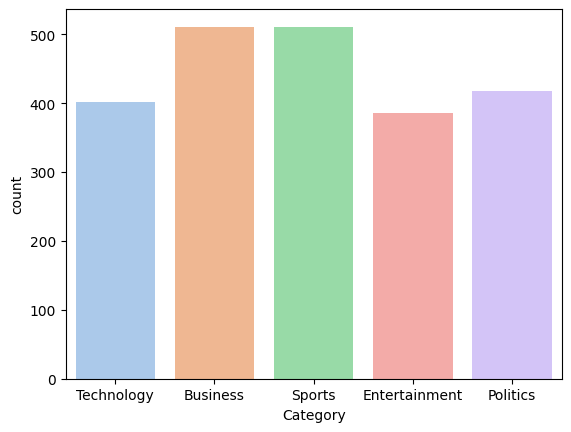

In [10]:
sns.countplot(df, x="Category", 
              hue="Category", 
              legend=False, 
              palette="pastel")

### Text Data Analysis

<Axes: xlabel='article_length', ylabel='Density'>

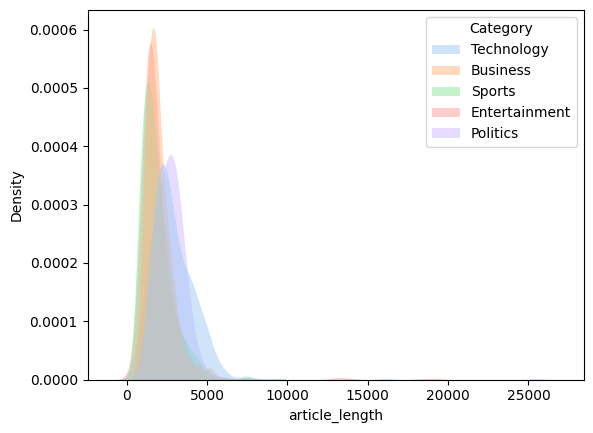

In [11]:
df["article_length"] = [len(art) for art in df["Article"]]

sns.kdeplot(df,
            x="article_length",
            hue="Category",
            fill=True, 
            common_norm=False, 
            palette="pastel",
            alpha=.5, 
            linewidth=0)

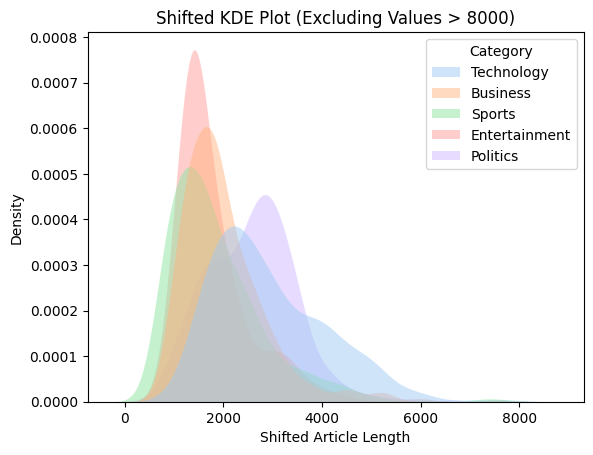

In [12]:
# Filter out values greater than 8000
df_filtered = df[df["article_length"] <= 8000]

# Plot the shifted KDE plot
sns.kdeplot(df_filtered,
            x="article_length",
            hue="Category",
            fill=True, 
            common_norm=False, 
            palette="pastel",
            alpha=.5, 
            linewidth=0)

plt.title("Shifted KDE Plot (Excluding Values > 8000)")
plt.xlabel("Shifted Article Length")
plt.show()

### Illustrate the insights based on EDA
Bar plot shows a higher frequency of business-related articles, suggesting a focus on finance and investment news."

## Data Preprocessing

### Dubplicate check

In [13]:
df.head()

,Category,Article,article_length
0,Technology,tv future in the hands of viewers with home th...,4333
1,Business,worldcom boss left books alone former worldc...,1842
2,Sports,tigers wary of farrell gamble leicester say ...,1342
3,Sports,yeading face newcastle in fa cup premiership s...,2176
4,Entertainment,ocean s twelve raids box office ocean s twelve...,1579


In [14]:
df.drop(columns=["article_length"], inplace= True)
df.head()

,Category,Article
0,Technology,tv future in the hands of viewers with home th...
1,Business,worldcom boss left books alone former worldc...
2,Sports,tigers wary of farrell gamble leicester say ...
3,Sports,yeading face newcastle in fa cup premiership s...
4,Entertainment,ocean s twelve raids box office ocean s twelve...


In [15]:
df[df.duplicated()]

,Category,Article
85,Politics,hague given up his pm ambition former conser...
301,Politics,fox attacks blair s tory lies tony blair lie...
496,Technology,microsoft gets the blogging bug software giant...
543,Business,economy strong in election year uk businesse...
582,Entertainment,ray dvd beats box office takings oscar-nominat...
...,...,...
2206,Politics,kennedy questions trust of blair lib dem leade...
2207,Technology,california sets fines for spyware the makers o...
2213,Technology,progress on new internet domains by early 2005...
2215,Technology,junk e-mails on relentless rise spam traffic i...


In [16]:
df = df.drop_duplicates(keep='last')

### Data Spliting

In [17]:
df["Category"].value_counts()

Category
Sports           504
Business         503
Politics         403
Entertainment    369
Technology       347
Name: count, dtype: int64

In [18]:
'''
To split your data into train and test sets while ensuring that the categories are balanced, WE use stratified sampling. 
'''

X = df.drop(columns=["Category"])
y = df["Category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.2,
    stratify=y,
    random_state=42
)

In [19]:
y_train.value_counts()

Category
Sports           403
Business         402
Politics         322
Entertainment    295
Technology       278
Name: count, dtype: int64

In [20]:
y_test.value_counts()

Category
Sports           101
Business         101
Politics          81
Entertainment     74
Technology        69
Name: count, dtype: int64

### Text Data Preprocessing

In [21]:
X_train["Article"][2]

'tigers wary of farrell  gamble  leicester say they will not be rushed into making a bid for andy farrell should the great britain rugby league captain decide to switch codes.   we and anybody else involved in the process are still some way away from going to the next stage   tigers boss john wells told bbc radio leicester.  at the moment  there are still a lot of unknowns about andy farrell  not least his medical situation.  whoever does take him on is going to take a big  big gamble.  farrell  who has had persistent knee problems  had an operation on his knee five weeks ago and is expected to be out for another three months. leicester and saracens are believed to head the list of rugby union clubs interested in signing farrell if he decides to move to the 15-man game.  if he does move across to union  wells believes he would better off playing in the backs  at least initially.  i m sure he could make the step between league and union by being involved in the centre   said wells.  i t

<Axes: ylabel='Article'>

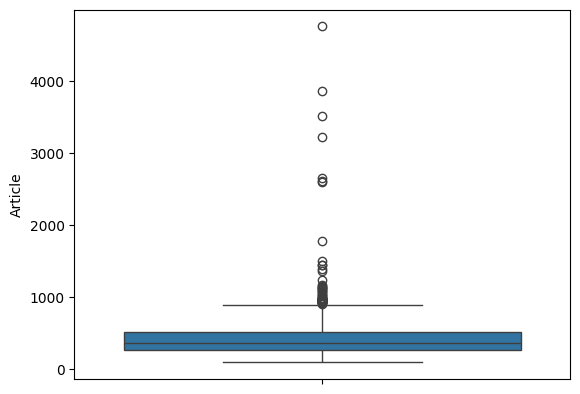

In [22]:
sns.boxplot(X_train['Article'].str.split(" ").str.len())

In [23]:
X_train["Article"] = X_train["Article"].apply(lambda x: word_tokenize(x))
print(X_train["Article"][2])

['tigers', 'wary', 'of', 'farrell', 'gamble', 'leicester', 'say', 'they', 'will', 'not', 'be', 'rushed', 'into', 'making', 'a', 'bid', 'for', 'andy', 'farrell', 'should', 'the', 'great', 'britain', 'rugby', 'league', 'captain', 'decide', 'to', 'switch', 'codes', '.', 'we', 'and', 'anybody', 'else', 'involved', 'in', 'the', 'process', 'are', 'still', 'some', 'way', 'away', 'from', 'going', 'to', 'the', 'next', 'stage', 'tigers', 'boss', 'john', 'wells', 'told', 'bbc', 'radio', 'leicester', '.', 'at', 'the', 'moment', 'there', 'are', 'still', 'a', 'lot', 'of', 'unknowns', 'about', 'andy', 'farrell', 'not', 'least', 'his', 'medical', 'situation', '.', 'whoever', 'does', 'take', 'him', 'on', 'is', 'going', 'to', 'take', 'a', 'big', 'big', 'gamble', '.', 'farrell', 'who', 'has', 'had', 'persistent', 'knee', 'problems', 'had', 'an', 'operation', 'on', 'his', 'knee', 'five', 'weeks', 'ago', 'and', 'is', 'expected', 'to', 'be', 'out', 'for', 'another', 'three', 'months', '.', 'leicester', 'and

In [24]:
# Import the english stop words list from NLTK
nltk.download("stopwords")
stopwords_english = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/varun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
'''
1. Stop word removal.
2. Punctuation removal.
3. Lemmatization 
'''
lemmatizer = WordNetLemmatizer()


X_train["Article"] = X_train["Article"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x if (word.lower() not in stopwords_english) and (word not in string.punctuation)])
print(X_train["Article"][2])

['tiger', 'wary', 'farrell', 'gamble', 'leicester', 'say', 'rushed', 'making', 'bid', 'andy', 'farrell', 'great', 'britain', 'rugby', 'league', 'captain', 'decide', 'switch', 'code', 'anybody', 'else', 'involved', 'process', 'still', 'way', 'away', 'going', 'next', 'stage', 'tiger', 'bos', 'john', 'well', 'told', 'bbc', 'radio', 'leicester', 'moment', 'still', 'lot', 'unknown', 'andy', 'farrell', 'least', 'medical', 'situation', 'whoever', 'take', 'going', 'take', 'big', 'big', 'gamble', 'farrell', 'persistent', 'knee', 'problem', 'operation', 'knee', 'five', 'week', 'ago', 'expected', 'another', 'three', 'month', 'leicester', 'saracen', 'believed', 'head', 'list', 'rugby', 'union', 'club', 'interested', 'signing', 'farrell', 'decides', 'move', '15-man', 'game', 'move', 'across', 'union', 'well', 'belief', 'would', 'better', 'playing', 'back', 'least', 'initially', 'sure', 'could', 'make', 'step', 'league', 'union', 'involved', 'centre', 'said', 'well', 'think', 'england', 'would', 'pr

### Feature Engineering

In [26]:
X_train["Article"] = X_train["Article"].apply(lambda x: " ".join(x))
print(X_train["Article"][2])

tiger wary farrell gamble leicester say rushed making bid andy farrell great britain rugby league captain decide switch code anybody else involved process still way away going next stage tiger bos john well told bbc radio leicester moment still lot unknown andy farrell least medical situation whoever take going take big big gamble farrell persistent knee problem operation knee five week ago expected another three month leicester saracen believed head list rugby union club interested signing farrell decides move 15-man game move across union well belief would better playing back least initially sure could make step league union involved centre said well think england would prefer progress position back row make use rugby league skill within forward jury whether cross divide club balance struck cost gamble option bringing ready-made replacement


In [27]:
X_test["Article"] = X_test["Article"].apply(lambda x: word_tokenize(x))
X_test["Article"] = X_test["Article"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x if (word.lower() not in stopwords_english) and (word not in string.punctuation)])
X_test["Article"] = X_test["Article"].apply(lambda x: " ".join(x))

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using inbuilt TfidfVectorizer() function to calculate TF-IDF
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_vectorizer.fit(X_train["Article"])

input_representation = tf_idf_vectorizer.transform(X_train["Article"]).toarray()
test_data = tf_idf_vectorizer.transform(X_test["Article"]).toarray()

# Create a DataFrame from the sparse matrix
df_check = pd.DataFrame(
    input_representation,  # Convert sparse matrix to dense array
    columns=tf_idf_vectorizer.get_feature_names_out(),  # Feature names
    index=X_train["Article"]  # Optional, use the text as the index
)

# Display the resulting DataFrame
display(df_check.head(2))

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,zonealarm,zoom,zooropa,zornotza,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
Article,,,,,,,,,,,,,,,,,,,,,
labour eu propaganda taxpayer subsidised propaganda exercise eu used lull british public false sense security say tory shadow foreign secretary michael ancram told mp new white paper part trying soften opinion ahead referendum eu constitution claim denied foreign secretary jack straw accused tory running scared debate eu cooperation would help get better uk immigration control argued mr straw used thursday common debate launch new white paper prospect eu 2005. security stability prosperity would key theme uk took chairmanship eu july said mr straw africa climate change would also feature highly said uk trying ensure future eu budget limited 1 europe economic output spent add value mr straw promised continue ensure uk budget rebate secured 1984 margaret thatcher fully justified like country veto change proposed area said mr ancram condemned document foreign office say cost £2 500 design print deliver reason government involved taxpayer subsidised propaganda exercise try sell new eu country advance forthcoming referendum general election asked tory spokesman also criticised government claiming eu constitution would make europe easier understand government last week publish commentary 500 page try explain easy simple constitution british people said trying kid proposed question constitution referendum united kingdom approve treaty establishing constitution european union electoral commission thursday said satisfied question easy understand government suggested referendum constitution could take place spring 2006 tory set campaign vote mr ancram said minister prolonging uncertainty putting vote latest date possible foreign secretary hit back saying tory attitude europe helped keep party power decade mr straw argued cooperation european partner could bring level playing field immigration asylum control setting face thing added liberal democrat sir menzies campbell said uk ignore need reform eu common agricultural policy change particularly important developing country wanting access market argued sir menzies among worried plan backed uk lift arm embargo imposed china tiananmen square massacre mr straw said decision taken chinese human right improved enough,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
border rail link campaign rally campaigner stage rally calling border rail link closed 1969 reopened mark 36th anniversary line closure ran edinburgh border carlisle walk tweedbank anne borthwick campaign border rail said reopening waverley line would restore area prosperity msps considering reintroduction passenger rail service midlothian border campaigner said reopening waverley line could cost £100m would huge economic boost border 2000 border council said area economy suffered since closure m borthwick said lobby group determined keep pressure scottish executive hoping many people join u march mark 36th anniversary closure waverley line said campaign border rail biggest independent lobby group scotland lobbying tirelessly reinstatement rail service border eventually carlisle believe time scottish executive commit first phase project pledging fund line edinburgh tweedbank first instance investigate extending line future m borthwick said reopening line would prosperous move protect character scottish border study 2000 commissioned executive scottish border council midlothian council scottish border enterprise found half-hourly service tweedbank edinburgh could cover operating cost also found half-hourly service gorebridge edinburgh could cover operating cost freight railway joining west coast main line longtown could also reinstated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Building

### Random Forest as Baseline Model

In [29]:
y_train.value_counts()

Category
Sports           403
Business         402
Politics         322
Entertainment    295
Technology       278
Name: count, dtype: int64

In [30]:
y_train.unique().tolist()

['Politics', 'Business', 'Sports', 'Technology', 'Entertainment']

In [31]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,         # Number of trees
    max_depth=20,             # Depth of each tree
    max_features='sqrt',      # Features to consider at each split
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1                 # Use all available cores
)

# Train the model
rf_model.fit(input_representation, y_train)

# Predict on test data
y_pred = rf_model.predict(test_data)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=y_train.unique().tolist()))


               precision    recall  f1-score   support

     Politics       0.95      0.96      0.96       101
     Business       0.99      0.97      0.98        74
       Sports       0.97      0.96      0.97        81
   Technology       0.99      1.00      1.00       101
Entertainment       0.94      0.94      0.94        69

     accuracy                           0.97       426
    macro avg       0.97      0.97      0.97       426
 weighted avg       0.97      0.97      0.97       426



### Hyperparameter Tuning - Random Forest Classifier: GridSearch

In [32]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 150],
#     'max_depth': [20, 30],
#     'max_features': ['sqrt'],
#     'class_weight': ['balanced']
# }

# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=42),
#     param_grid,
#     cv=3,
#     scoring='f1_macro',
#     n_jobs=-1
# )

# grid_search.fit(input_representation, y_train)
# print("Best Parameters:", grid_search.best_params_)

In [33]:
# # Predict on test data
# y_pred = grid_search.predict(test_data)

# # Evaluate the model
# print(classification_report(y_test, y_pred, target_names=y_train.unique().tolist()))

### Incorporating Advanced Models : RNN

In [34]:
y_train

1033         Politics
1717         Politics
625          Business
1650         Politics
1248           Sports
            ...      
10      Entertainment
1936       Technology
2059         Politics
355          Business
1376         Business
Name: Category, Length: 1700, dtype: object

In [35]:
'''
One Hot Encode Target Values
'''

train_Y = pd.get_dummies(y_train).values.argmax(axis=1)
test_Y = pd.get_dummies(y_test).values.argmax(axis=1)

In [36]:
train_Y

array([2, 2, 0, ..., 2, 0, 0])

In [37]:
validation = test_Y
validation

array([4, 1, 3, 1, 2, 2, 1, 0, 0, 1, 2, 4, 0, 2, 2, 3, 2, 2, 0, 3, 2, 3,
       1, 2, 2, 0, 0, 2, 2, 1, 4, 1, 3, 1, 4, 4, 0, 0, 1, 4, 0, 0, 1, 2,
       0, 0, 3, 0, 2, 0, 1, 3, 3, 2, 0, 1, 4, 3, 4, 0, 3, 3, 4, 2, 1, 4,
       2, 3, 2, 2, 1, 0, 1, 2, 2, 3, 0, 0, 3, 3, 0, 0, 0, 0, 1, 1, 3, 3,
       0, 1, 0, 4, 3, 4, 4, 2, 3, 4, 4, 3, 3, 2, 0, 0, 3, 2, 2, 2, 4, 4,
       2, 2, 2, 3, 2, 4, 2, 4, 0, 3, 3, 3, 3, 0, 3, 0, 0, 3, 4, 1, 2, 2,
       3, 2, 3, 2, 0, 0, 0, 3, 1, 1, 2, 0, 3, 1, 3, 1, 1, 2, 4, 3, 0, 3,
       3, 4, 3, 0, 4, 2, 3, 1, 4, 4, 0, 2, 1, 1, 3, 3, 3, 4, 4, 3, 4, 0,
       0, 2, 2, 2, 3, 2, 3, 0, 4, 3, 2, 1, 3, 0, 0, 1, 3, 1, 4, 3, 4, 4,
       4, 1, 2, 3, 1, 2, 1, 3, 3, 4, 3, 1, 0, 1, 3, 3, 3, 0, 2, 0, 4, 4,
       4, 2, 1, 1, 4, 0, 3, 1, 2, 0, 3, 2, 2, 2, 3, 4, 0, 1, 3, 4, 4, 1,
       0, 2, 3, 3, 0, 4, 1, 1, 3, 0, 0, 1, 2, 3, 0, 3, 4, 1, 4, 4, 2, 3,
       1, 0, 1, 4, 1, 4, 4, 3, 1, 1, 0, 3, 4, 4, 3, 2, 0, 1, 3, 1, 3, 4,
       0, 0, 3, 1, 4, 1, 2, 3, 0, 0, 0, 1, 0, 4, 3,

In [38]:
X_train

,Article
1033,labour eu propaganda taxpayer subsidised propa...
1717,border rail link campaign rally campaigner sta...
625,nigeria boost cocoa production government nige...
1650,brown poll campaign move denied government den...
1248,sullivan quick hail italian ireland coach eddi...
...,...
10,berlin cheer anti-nazi film german movie anti-...
1936,power people say hp digital revolution focused...
2059,blair brown criticised mp labour mp angrily cr...
355,eu slow economic reform eu country failed put ...


In [39]:
X_train.reset_index(drop=True)

,Article
0,labour eu propaganda taxpayer subsidised propa...
1,border rail link campaign rally campaigner sta...
2,nigeria boost cocoa production government nige...
3,brown poll campaign move denied government den...
4,sullivan quick hail italian ireland coach eddi...
...,...
1695,berlin cheer anti-nazi film german movie anti-...
1696,power people say hp digital revolution focused...
1697,blair brown criticised mp labour mp angrily cr...
1698,eu slow economic reform eu country failed put ...


In [40]:
'''
Tokenization
'''
max_sentence_len = 1000

def tokenize_and_pad(inp_text, max_len, tok):

    text_seq = tok.texts_to_sequences(inp_text)
    text_seq = pad_sequences(text_seq, maxlen=max_len, padding='post')

    return text_seq

text_tok = Tokenizer()
text_tok.fit_on_texts(X_train["Article"])
train_text_X = tokenize_and_pad(inp_text=X_train["Article"], max_len=max_sentence_len, tok=text_tok)
test_text_X = tokenize_and_pad(inp_text=X_test["Article"], max_len=max_sentence_len, tok=text_tok)
vocab_size = len(text_tok.word_index)+1

print("Overall text vocab size", vocab_size)

Overall text vocab size 24517


In [41]:
len(train_text_X[0])

1000

In [42]:
'''
Latent dimension: Dimension of the weight matrix U, V, W
Embedding dimension: Dimension of the word embeddings at the embedding layer
'''

latent_dim=512
embedding_dim=256

### RNN Pipeline

In [43]:
'''
RNN Pipeline
'''
total_classes = df["Category"].nunique()

# Set seeds for reproducibility
seed = 56
tf.random.set_seed(seed)
np.random.seed(seed)

# Create the model
model = Sequential(name="FlipItNewsMultiClassClassificationModel")
model.add(Embedding(vocab_size, embedding_dim, input_shape=(len(train_text_X[0]),), trainable=True))
model.add(SimpleRNN(latent_dim, return_sequences=False, activation='tanh'))
model.add(Dense(128, activation='softmax'))
model.add(Dense(64, activation='softmax'))
model.add(Dense(total_classes, activation='softmax'))

# Model summary to see the architecture
model.summary()

/home/varun/Documents/MS/Business Cases/FlipItNews/.flipitnews_env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "FlipItNewsMultiClassClassificationModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 256)      │     6,276,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,744,325 (25.73 MB)

 Trainable params: 6,744,325 (25.73 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
tf.random.set_seed(seed)
np.random.seed(seed)

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy',
                               mode='max',
                               verbose=1,
                               patience=5)

model.fit(x=train_text_X, y=train_Y,
          validation_data=(test_text_X, test_Y),
          batch_size=32,
          epochs=100,
          callbacks=[early_stopping]
        )

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 514ms/step - accuracy: 0.2289 - loss: 1.6082 - val_accuracy: 0.2371 - val_loss: 1.6044
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 499ms/step - accuracy: 0.2470 - loss: 1.6023 - val_accuracy: 0.2371 - val_loss: 1.6010
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 501ms/step - accuracy: 0.2470 - loss: 1.5994 - val_accuracy: 0.2371 - val_loss: 1.5992
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 506ms/step - accuracy: 0.2470 - loss: 1.5978 - val_accuracy: 0.2371 - val_loss: 1.5982
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 502ms/step - accuracy: 0.2463 - loss: 1.5969 - val_accuracy: 0.2371 - val_loss: 1.5977
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 503ms/step - accuracy: 0.2395 - loss: 1.5965 - val_accuracy: 0.2371 - val_loss: 1.5974
Epoch 6: early stopping


### LSTM Pipeline

In [45]:
'''
LSTM Pipeline
'''

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_shape=(len(train_text_X[0]),), trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer
model.add(Dense(64, activation='relu'))  # Dense layer
model.add(Dropout(0.5))
model.add(Dense(total_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Model summary to see the architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1000, 256)      │     6,276,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 1000, 256)      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │       142,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,425,941 (24.51 MB)

 Trainable params: 6,425,941 (24.51 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.fit(x=train_text_X, y=train_Y,
          validation_data=(test_text_X, test_Y),
          batch_size=32,
          epochs=100,
          callbacks=[early_stopping])

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 297ms/step - accuracy: 0.2169 - loss: 1.6079 - val_accuracy: 0.2371 - val_loss: 1.5993
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.2403 - loss: 1.6050 - val_accuracy: 0.2371 - val_loss: 1.5987
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.2374 - loss: 1.6004 - val_accuracy: 0.2371 - val_loss: 1.5992
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - accuracy: 0.2577 - loss: 1.6004 - val_accuracy: 0.2371 - val_loss: 1.5987
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 288ms/step - accuracy: 0.2503 - loss: 1.6036 - val_accuracy: 0.2371 - val_loss: 1.5978
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 292ms/step - accuracy: 0.2543 - loss: 1.5988 - val_accuracy: 0.2371 - val_loss: 1.5980
Epoch 6: early stopping


**Our embedding layers seem like they are not able to learn much from the vocabulary.**  
**The reason could be that we are resource-constrained and can't have a large batch size, or the vocabulary may not be good enough.**

### BERT : Using Pre-Trained Embedding model to create vector representation of the input data.

In [47]:
from transformers import BertTokenizer, BertModel
import torch
from tensorflow.keras.utils import to_categorical

/home/varun/Documents/MS/Business Cases/FlipItNews/.flipitnews_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
X.reset_index(drop=True, inplace=True)
X.head()

,Article
0,tv future in the hands of viewers with home th...
1,worldcom boss left books alone former worldc...
2,tigers wary of farrell gamble leicester say ...
3,yeading face newcastle in fa cup premiership s...
4,howard hits back at mongrel jibe michael howar...


In [49]:
y.reset_index(drop=True, inplace=True)
y.head()

0    Technology
1      Business
2        Sports
3        Sports
4      Politics
Name: Category, dtype: object

In [50]:
len(X["Article"].tolist())

2126

In [51]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

embeddings = []

# Precompute embeddings
for sentence in X["Article"].tolist():
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token embedding
        embeddings.append(cls_embedding.cpu().numpy())

# Convert to a NumPy array
X = np.vstack(embeddings)  # Shape: (num_samples, hidden_size)

In [52]:
len(X)

2126

In [53]:
len(X[0])

768

In [54]:
'''
One Hot Encode Target Values
'''

labels = pd.get_dummies(df["Category"]).values.argmax(axis=1)

In [55]:
y_one_hot = to_categorical(labels, num_classes=total_classes)

In [56]:
y_one_hot

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [57]:
len(X)

2126

In [58]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y_one_hot, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
    )

In [59]:
len(X_train)

1700

In [60]:
# Reshape for LSTM (samples, timesteps, features)
X_train_reshaped = X_train[:, np.newaxis, :]  # Shape: (batch_size, 1, hidden_size)
X_val_reshaped = X_val[:, np.newaxis, :]

In [61]:
X.shape[1]

768

In [62]:
X_train_reshaped.shape

(1700, 1, 768)

In [63]:
X_train.shape

(1700, 768)

In [64]:
y_train.shape

(1700, 5)

In [65]:
# Set seeds for reproducibility
seed = 56
tf.random.set_seed(seed)
np.random.seed(seed)

model = Sequential(name="FlipItNewsMultiClassClassificationModel")
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(total_classes, activation='softmax'))
    
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
model.summary()

Model: "FlipItNewsMultiClassClassificationModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [67]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               mode='max',
                               verbose=1,
                               patience=5)

model.fit(x=X_train_reshaped, y=y_train,
          validation_data=(X_val_reshaped, y_val),
          batch_size=32,
          epochs=100,
          callbacks=[early_stopping]
        )

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6654 - loss: 0.9620 - val_accuracy: 0.9531 - val_loss: 0.1454
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9497 - loss: 0.1446 - val_accuracy: 0.9624 - val_loss: 0.1159
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9748 - loss: 0.0830 - val_accuracy: 0.9554 - val_loss: 0.1449
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9751 - loss: 0.0731 - val_accuracy: 0.9531 - val_loss: 0.1479
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9785 - loss: 0.0595 - val_accuracy: 0.9624 - val_loss: 0.1237
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9889 - loss: 0.0361 - val_accuracy: 0.9484 - val_loss: 0.1527
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9912 - loss: 0.0301 - val_accuracy: 0.9484 - val_loss: 0.1907
Epoch 7: early stopping


In [68]:
# Predict probabilities
y_val_pred_prob = model.predict(X_val_reshaped)

# Convert probabilities to class predictions (for multi-class classification)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [69]:
y_val.argmax(axis=1)

array([4, 1, 3, 1, 2, 2, 1, 0, 0, 1, 2, 4, 0, 2, 2, 3, 2, 2, 0, 3, 2, 3,
       1, 2, 2, 0, 0, 2, 2, 1, 4, 1, 3, 1, 4, 4, 0, 0, 1, 4, 0, 0, 1, 2,
       0, 0, 3, 0, 2, 0, 1, 3, 3, 2, 0, 1, 4, 3, 4, 0, 3, 3, 4, 2, 1, 4,
       2, 3, 2, 2, 1, 0, 1, 2, 2, 3, 0, 0, 3, 3, 0, 0, 0, 0, 1, 1, 3, 3,
       0, 1, 0, 4, 3, 4, 4, 2, 3, 4, 4, 3, 3, 2, 0, 0, 3, 2, 2, 2, 4, 4,
       2, 2, 2, 3, 2, 4, 2, 4, 0, 3, 3, 3, 3, 0, 3, 0, 0, 3, 4, 1, 2, 2,
       3, 2, 3, 2, 0, 0, 0, 3, 1, 1, 2, 0, 3, 1, 3, 1, 1, 2, 4, 3, 0, 3,
       3, 4, 3, 0, 4, 2, 3, 1, 4, 4, 0, 2, 1, 1, 3, 3, 3, 4, 4, 3, 4, 0,
       0, 2, 2, 2, 3, 2, 3, 0, 4, 3, 2, 1, 3, 0, 0, 1, 3, 1, 4, 3, 4, 4,
       4, 1, 2, 3, 1, 2, 1, 3, 3, 4, 3, 1, 0, 1, 3, 3, 3, 0, 2, 0, 4, 4,
       4, 2, 1, 1, 4, 0, 3, 1, 2, 0, 3, 2, 2, 2, 3, 4, 0, 1, 3, 4, 4, 1,
       0, 2, 3, 3, 0, 4, 1, 1, 3, 0, 0, 1, 2, 3, 0, 3, 4, 1, 4, 4, 2, 3,
       1, 0, 1, 4, 1, 4, 4, 3, 1, 1, 0, 3, 4, 4, 3, 2, 0, 1, 3, 1, 3, 4,
       0, 0, 3, 1, 4, 1, 2, 3, 0, 0, 0, 1, 0, 4, 3,

In [70]:
# Assuming y_val is in the same format (class labels)
print("Accuracy:", accuracy_score(y_val.argmax(axis=1), y_val_pred))

# Detailed classification report
print("Classification Report:\n", classification_report(y_val.argmax(axis=1), y_val_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_val.argmax(axis=1), y_val_pred))

Accuracy: 0.9483568075117371
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.93       101
           1       0.99      0.95      0.97        74
           2       0.92      0.96      0.94        81
           3       0.99      1.00      1.00       101
           4       0.84      0.99      0.91        69

    accuracy                           0.95       426
   macro avg       0.95      0.95      0.95       426
weighted avg       0.95      0.95      0.95       426

Confusion Matrix:
 [[ 87   1   7   0   6]
 [  0  70   0   0   4]
 [  0   0  78   0   3]
 [  0   0   0 101   0]
 [  0   0   0   1  68]]


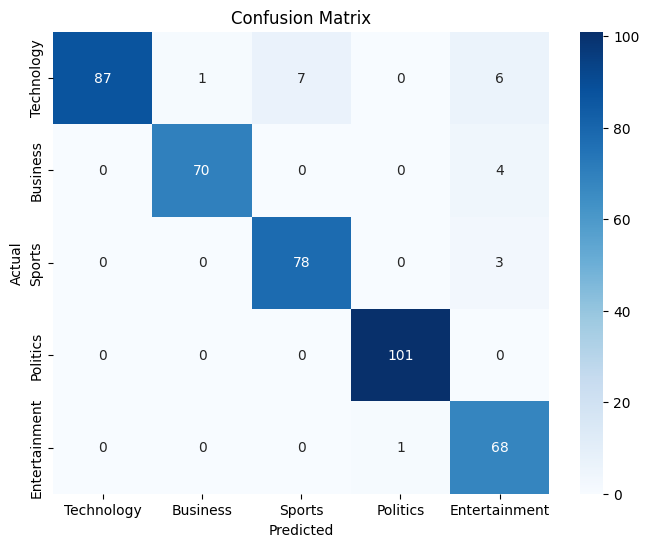

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_val.argmax(axis=1), y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=y.unique().tolist(), yticklabels=y.unique().tolist())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Case Study Interpretation

**1. Dataset Overview**  
We have a total of 5 news article categories:  
1. Entertainment  
2. Politics  
3. Sports  
4. Business  
5. Technology  

**2. Article Distribution**  
Most of the articles belong to the Sports and Business categories.  

**3. Technology Category**  
Out of the entire dataset, 347 articles belong to the Technology category.  

**4. Stop Words**  
**Stop Words** are common words in a language (e.g., "is," "and," "the") that carry little semantic meaning. These words are often removed during text preprocessing to reduce noise in text analysis. Removing stop words helps focus on meaningful terms, improving the efficiency and accuracy of text-based tasks like Natural Language Processing (NLP).  

**5. Stemming vs Lemmatization**  
**Stemming** reduces words to their root form by chopping off prefixes or suffixes, often ignoring grammatical correctness (e.g., "running" → "run").  
**Lemmatization**, on the other hand, converts words to their base or dictionary form, ensuring grammatical accuracy (e.g., "running" → "run" or "better" → "good").  

Lemmatization is more precise but computationally expensive compared to stemming.  

**6. TF-IDF vs Bag of Words**  
**TF-IDF** (Term Frequency-Inverse Document Frequency) is considered more efficient than **Bag of Words** because it assigns weights to words based on their importance, reducing the influence of common words while emphasizing rare, meaningful terms. In contrast, the Bag of Words model treats all terms equally, leading to higher dimensionality and less semantic insight.  

**7. Business Case Understanding**  
Based on the business case understanding, **Recall** should be our primary metric since we don't want to lose any customers who belong to a category but are not predicted correctly.  

**8. Model Comparison**  
From the models we trained, the **Neural Network with BERT embeddings** gave better results compared to **Random Forest with TF-IDF vector representation**. However, both models show a close competition in terms of Recall.  

**9. Data Splitting Strategy**  
We split the data in an 80:20 ratio, using stratified sampling to ensure class balance while training the models.